##### setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns


df = pd.read_csv('../data/ind_turnover.csv')
df = df.drop(columns=['EmployeeCount'])
df['Education'] = df['Education'].astype('category')
df['JobLevel'] = df['JobLevel'].astype('category')
df['PerformanceRating'] = df['PerformanceRating'].astype('category')

In [2]:
def plot_corr_bar(df):
    corr = df.drop(columns=['Attrition']).corrwith(df['Attrition']).sort_values(ascending=False)
    corr = corr[corr.abs() > .075]
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8, 6))
    sns.barplot(x=corr.values, y=corr.index, palette='viridis')
    plt.title('Feature Correlation with Attrition')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
def undersample(df, target_col='Attrition'):
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    return df_balanced.sample(frac=1, random_state=42)  # Shuffle the dataset

def boolify_ints(df):
    df = df.copy()
    for col in df.select_dtypes(include=['int']).columns:
        if col == 'Attrition':
            continue
        # create bool for int >75 percentile and <25 percentile
        threshold_high = df[col].quantile(0.75)
        threshold_low = df[col].quantile(0.25)
        df[f'{col}_high'] = (df[col] > threshold_high).astype(int)
        df[f'{col}_low'] = (df[col] < threshold_low).astype(int)

        # drop original int column
        df.drop(columns=[col], inplace=True)
    return df

def plot_increased_odds_ratio(df, target_col='Attrition', threshold=1.5, distance_from_one=None, p_value_threshold=None):
    odds_ratios = {}
    p_values = {}
    
    for col in df.columns:
        if col == target_col:
            continue
        contingency_table = pd.crosstab(df[col], df[target_col])
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            continue
        
        # Calculate odds ratio
        odds_ratio = (contingency_table.iloc[1,1] * contingency_table.iloc[0,0]) / (contingency_table.iloc[1,0] * contingency_table.iloc[0,1] + 1e-10)
        odds_ratios[col] = odds_ratio
        
        # Calculate p-value using chi-square test
        chi2, p_val, dof, expected = chi2_contingency(contingency_table)
        p_values[col] = p_val

    # Filter by odds ratio threshold (keep both increased and decreased odds)
    filtered_odds_ratios = odds_ratios.copy()
    
    # Filter by absolute distance from 1 if specified
    if distance_from_one is not None:
        filtered_odds_ratios = {k: v for k, v in filtered_odds_ratios.items() if abs(v - 1) > distance_from_one}
    
    # Filter by p-value if specified
    if p_value_threshold is not None:
        filtered_odds_ratios = {k: v for k, v in filtered_odds_ratios.items() if p_values[k] < p_value_threshold}
    
    sorted_odds_ratios = dict(sorted(filtered_odds_ratios.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(12, 10))
    sns.barplot(x=list(sorted_odds_ratios.values()), y=list(sorted_odds_ratios.keys()), palette='magma')
    title_parts = []
    if distance_from_one is not None:
        title_parts.append(f'Absolute distance from 1 > {distance_from_one}')
    if p_value_threshold is not None:
        title_parts.append(f'p-value < {p_value_threshold}')
    
    if title_parts:
        plt.title('Features with ' + ', '.join(title_parts))
    else:
        plt.title('All Features Odds Ratios')
    plt.xlabel('Odds Ratio')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    return sorted_odds_ratios

In [3]:
df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)
df = pd.get_dummies(df, drop_first=False)
df.set_index('EmployeeNumber', inplace=True)
df_balanced = undersample(df, target_col='Attrition')
df_bool = boolify_ints(df)
df_balanced_bool = boolify_ints(df_balanced)

/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_171668/3825043545.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette='viridis')


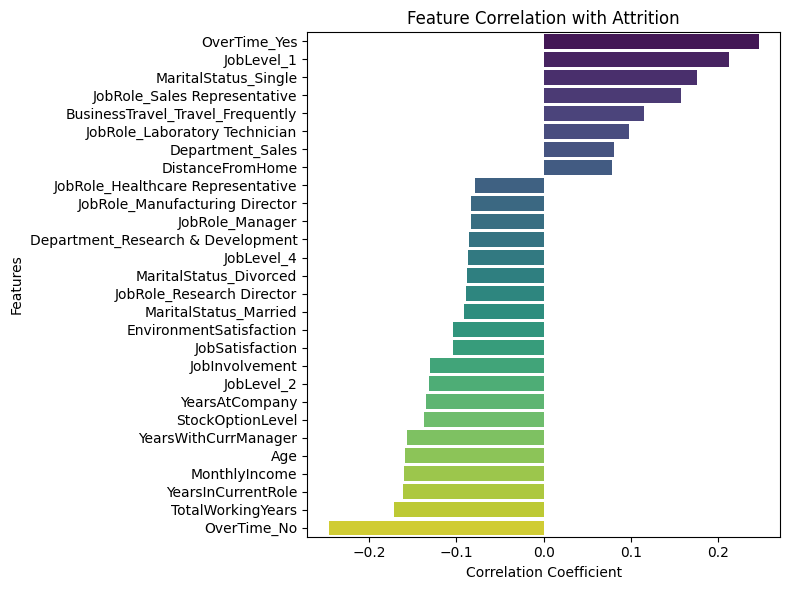

/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_171668/3825043545.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette='viridis')


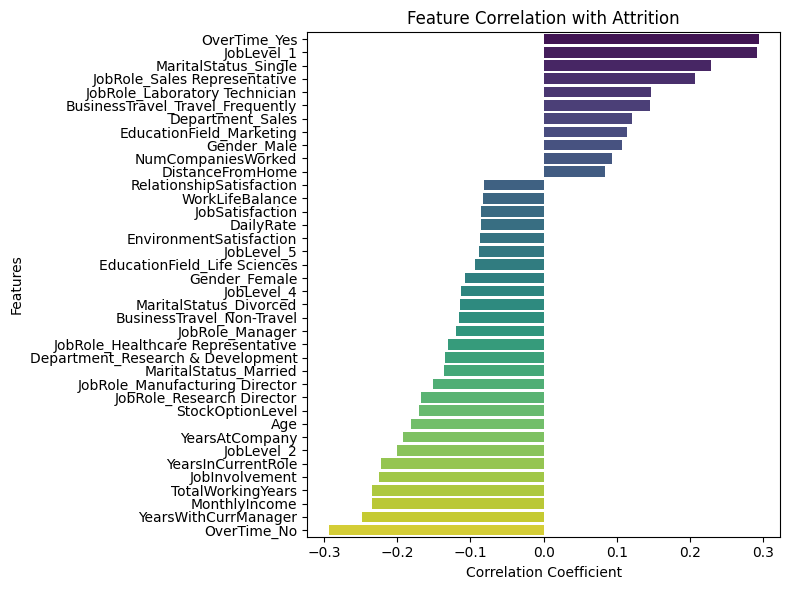

In [4]:
plot_corr_bar(df)
plot_corr_bar(df_balanced)

/tmp/ipykernel_171668/3825043545.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_odds_ratios.values()), y=list(sorted_odds_ratios.keys()), palette='magma')


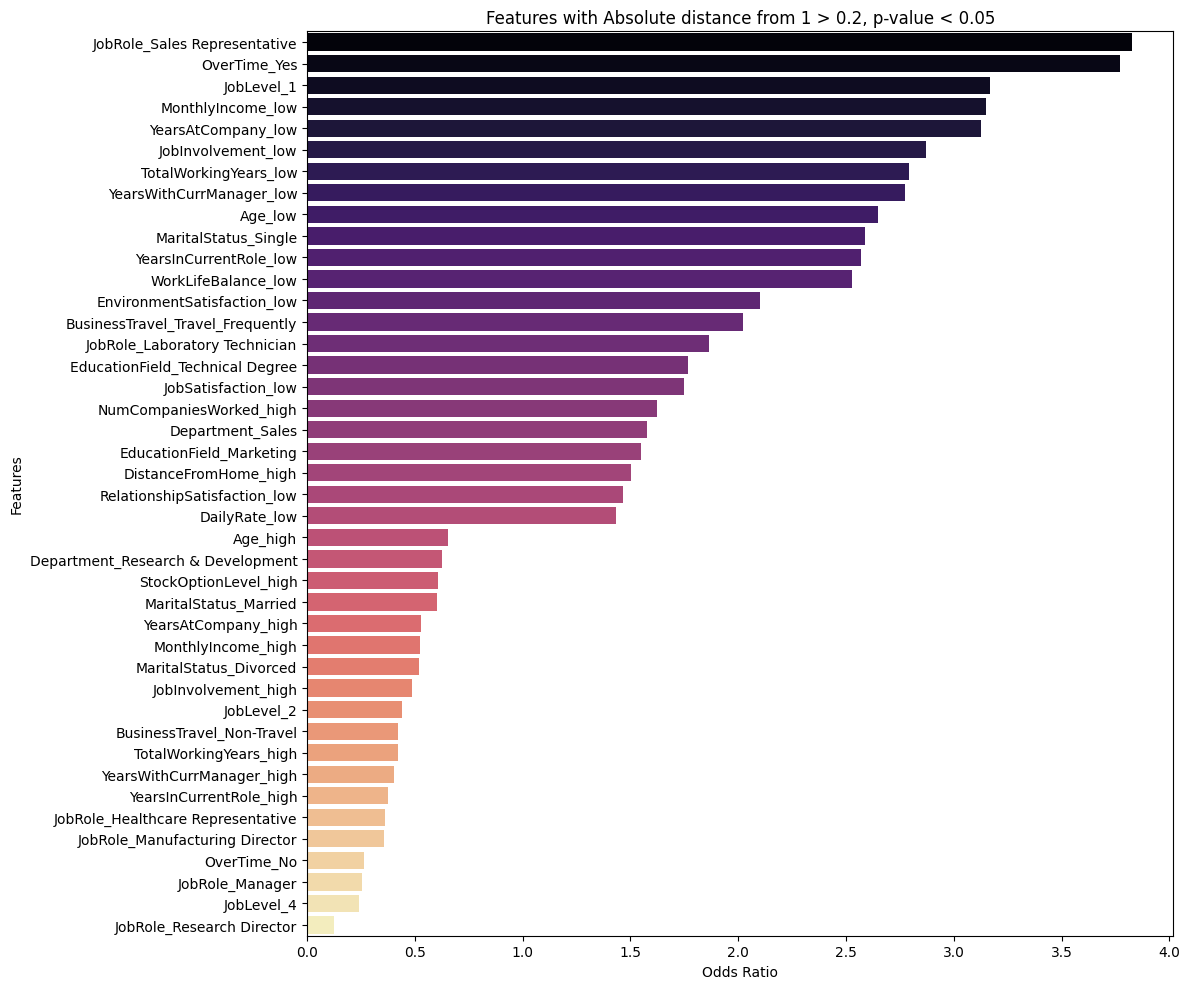

{'JobRole_Sales Representative': np.float64(3.827352941176433),
 'OverTime_Yes': np.float64(3.771248820383757),
 'JobLevel_1': np.float64(3.1680585106382892),
 'MonthlyIncome_low': np.float64(3.148424171679976),
 'YearsAtCompany_low': np.float64(3.1261111111111015),
 'JobInvolvement_low': np.float64(2.869421487603281),
 'TotalWorkingYears_low': np.float64(2.792328767123279),
 'YearsWithCurrManager_low': np.float64(2.7738376674546803),
 'Age_low': np.float64(2.6469833867676984),
 'MaritalStatus_Single': np.float64(2.587545787545781),
 'YearsInCurrentRole_low': np.float64(2.5705249841872155),
 'WorkLifeBalance_low': np.float64(2.525728987993117),
 'EnvironmentSatisfaction_low': np.float64(2.1015437392795824),
 'BusinessTravel_Travel_Frequently': np.float64(2.023952609890104),
 'JobRole_Laboratory Technician': np.float64(1.8631472081218219),
 'EducationField_Technical Degree': np.float64(1.7685853658536501),
 'JobSatisfaction_low': np.float64(1.7480922036031736),
 'NumCompaniesWorked_high

In [5]:
plot_increased_odds_ratio(df_bool, target_col='Attrition', distance_from_one=0.2, p_value_threshold=0.05)

# model

In [6]:
def fit_cat_boost_model(df, target_col='Attrition', cv_folds=5):
    from catboost import CatBoostClassifier
    from sklearn.model_selection import cross_val_score, GridSearchCV
    from sklearn.utils.class_weight import compute_class_weight
    
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Compute class weights
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes, class_weights))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Base model with overfitting prevention and class weights
    base_model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=4,
        l2_leaf_reg=3,
        random_strength=1,
        bagging_temperature=1,
        class_weights=class_weight_dict,
        verbose=False,
        random_state=42
    )
    
    # Cross-validation
    cv_scores = cross_val_score(base_model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')
    
    # Small parameter tuning
    param_grid = {
        'depth': [3, 4, 5],
        'learning_rate': [0.03, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5]
    }
    
    grid_search = GridSearchCV(
        CatBoostClassifier(iterations=300, class_weights=class_weight_dict, verbose=False, random_state=42),
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best CV score: {grid_search.best_score_:.4f}')
    
    # Train final model with best parameters
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {test_accuracy:.4f}')
    
    return best_model

In [7]:
model = fit_cat_boost_model(df_balanced_bool, target_col='Attrition', cv_folds=5)

Cross-validation scores: [0.73684211 0.81578947 0.77631579 0.69736842 0.8       ]
Mean CV accuracy: 0.7653 (+/- 0.0863)
Best parameters: {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
Best CV score: 0.7678
Test accuracy: 0.7474


In [8]:
imbalanced_model = fit_cat_boost_model(df_bool, target_col='Attrition', cv_folds=5)

Cross-validation scores: [0.83050847 0.85106383 0.85106383 0.8        0.8212766 ]
Mean CV accuracy: 0.8308 (+/- 0.0386)
Best parameters: {'depth': 5, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best CV score: 0.8478
Test accuracy: 0.8707


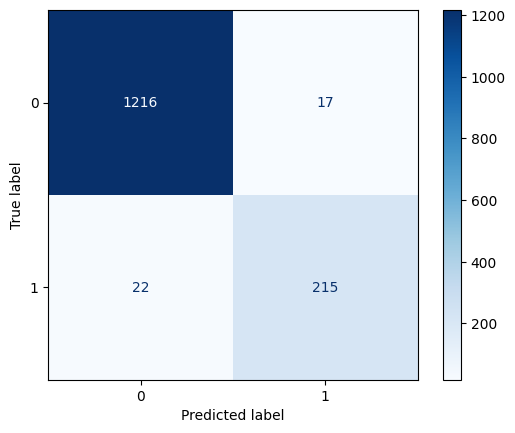

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = imbalanced_model.predict(df_bool.drop(columns=['Attrition']))
ConfusionMatrixDisplay.from_predictions(df_bool['Attrition'], y_pred, cmap='Blues')
plt.show()

# Shap

In [10]:
def get_shap_values(model, df, target_col='Attrition'):
    import shap

    X = df.drop(columns=[target_col])
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    shap.summary_plot(shap_values, X)
    return shap_values

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


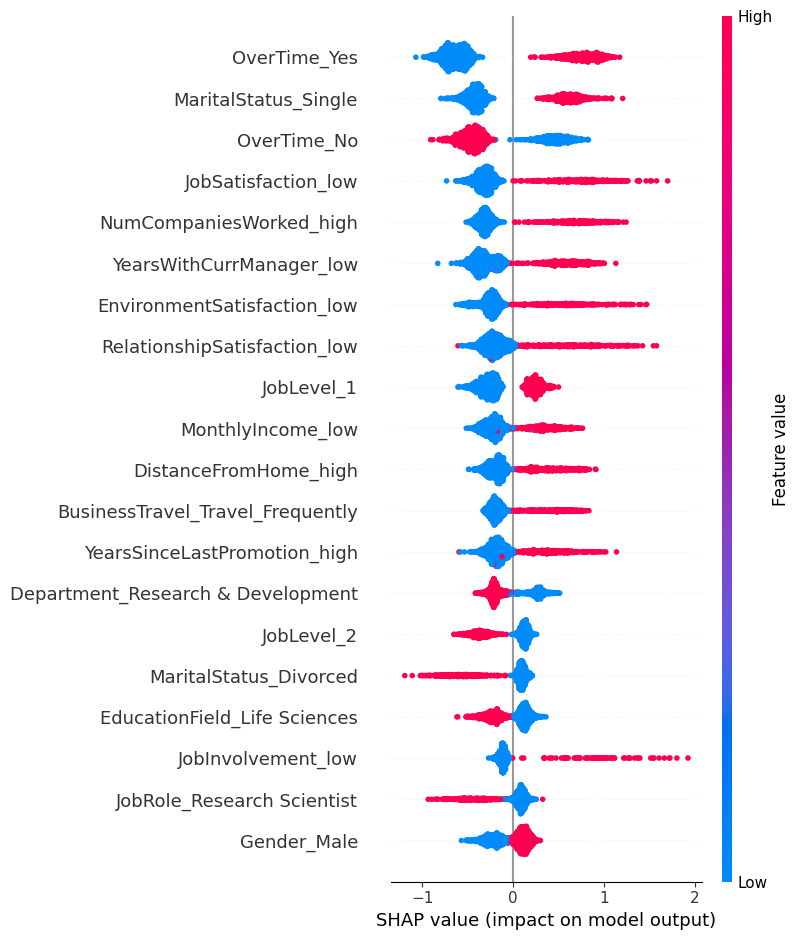

In [11]:
shap_values = get_shap_values(imbalanced_model, df_bool)

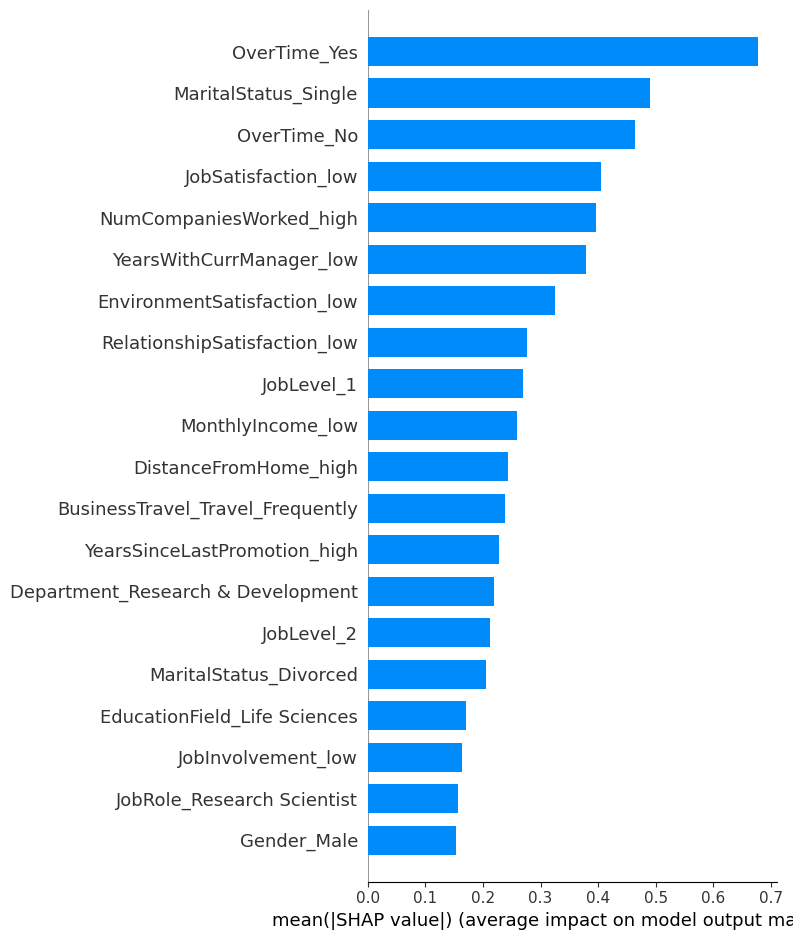

In [12]:
import shap


# plot summary bar
shap.summary_plot(shap_values, df_bool.drop(columns=['Attrition']), plot_type='bar')

In [15]:
df[df.index==1].T.head(50)

EmployeeNumber,1
Age,41
Attrition,1
DailyRate,1102
DistanceFromHome,1
EnvironmentSatisfaction,2
HourlyRate,94
JobInvolvement,3
JobSatisfaction,4
MonthlyIncome,5993
MonthlyRate,19479


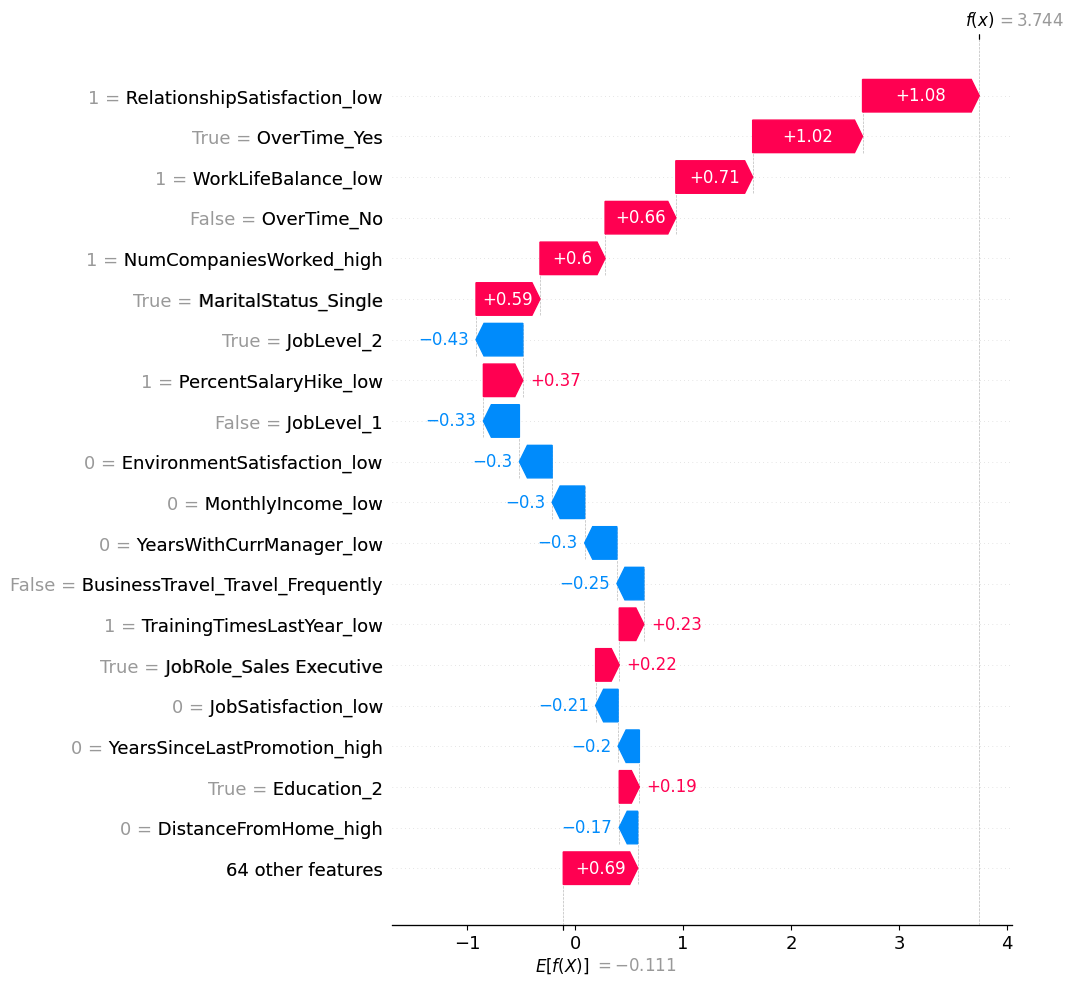

In [17]:
# plot waterfall
shap.waterfall_plot(shap_values[0], max_display=20)